In [1]:
import os
import sys

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset
from utils import export, show_side_by_side, show_features
from statistics import Statistics
from prob_opt import PredictStructs

In [61]:
class ScoreContainer:
    def __init__(self, data_dir, out_dir, prots):
        self.data_dir = data_dir
        self.out_dir = out_dir
        self.prots = prots
        
        sys.path.append('{}/{}/{}'.format(data_dir, prots[0], out_dir))
        import settings
        
        self.stats_data = Dataset(settings.stats_prots, settings.struct_dict, 
                                  data_dir, settings.glide_dir, settings.ifp_dir, settings.mcss_dir)
        self.stats_data.load({p:prot.lm.get_pdb() for p,prot in self.stats_data.proteins.items()})

        self.stats = Statistics(self.stats_data, settings.stats_prots, 
                                settings.num_stats_ligs, settings.num_stats_poses, 
                                settings.features, settings.smooth)
        
        self.predict_data = Dataset(prots, settings.struct_dict, 
                                    data_dir, settings.glide_dir, settings.ifp_dir, settings.mcss_dir)
        self.ps = {}
        for p in prots:
            self.ps[p] = PredictStructs(self.predict_data.proteins[p].docking, self.stats.evidence, 
                                        settings.features, settings.num_poses, settings.t)
        
        self.results = self.load_results()
        
    def load_results(self):
        results = {}
        for p in self.prots:
            results[p] = {}
            out_path = '{}/{}/{}'.format(self.data_dir, p, self.out_dir)
            for f in sorted(os.listdir(out_path)):
                if f.split('.')[-1] != 'out' or f[0] == '.': continue
                q = f.split('.')[0]
                results[p][q] = {}
                #self.predict_data.load({p:[q]})
                with open('{}/{}'.format(out_path, f)) as outf:
                    for line in outf:
                        line = line.strip().split(',')
                        if len(line) != 2: continue
                        if line[0] == 'max_score':
                            self.predict_data.load({p:results[p][q].keys()})
                            best_cluster = {l:p for l,p in results[p][q].items() if l != q}
                            check_sc = self.ps[p].joint_posterior(best_cluster)[0]
                            if abs(check_sc - float(line[1])) > 0.0001:
                                print q, check_sc, float(line[1])
                            continue
                        try:
                            results[p][q][line[0]] = int(line[1])
                        except:
                            #errors.add(q)
                            print f
                            print line

        return results
    
    def get_rmsd(self, p, q, l, glide=False):
        if glide:
            return self.predict_data.proteins[p].docking.ligands[l].poses[0].rmsd
        return self.predict_data.proteins[p].docking.ligands[l].poses[self.results[p][q][l]].rmsd
    
    def show_fps(self, p, q, num_i=10, size=2):
        self.predict_data.assign_weights({2:1,3:1,4:1,6:1,11:0.005})
        l_list = [q]+sorted([l for l in self.results[p][q] if l!=q])
        us_top = self.ps[p].ligset.get_poses(self.results[p][q])
        glide_top = self.ps[p].ligset.get_poses({l:0 for l in l_list})
        show_side_by_side(us_top, glide_top, l_list, 
                          t1='Our Top Poses', t2='Glide Top Poses', num_i=num_i, size=size)
        
    def show_feature(self, p, q, f_name, show_prob=True, show_x=False, size=2):
        k,kdef = f_name, self.stats.features[f_name]
        l_list = [q]+sorted([l for l in self.results[p][q] if l!=q])
        
        x1, log_p1 = self.ps[p].x(self.results[p][q],k,kdef,lig_order=l_list)
        x2, log_p2 = self.ps[p].x({l:0 for l in l_list},k,kdef,lig_order=l_list)
        
        us_top = self.ps[p].ligset.get_poses(self.results[p][q])
        glide_top = self.ps[p].ligset.get_poses({l:0 for l in l_list})
        
        if show_prob and np.sum(log_p1) != 0:
            print k, 'probability matrix'
            minval = min(np.min(log_p1[np.nonzero(log_p1)]),np.min(log_p2[np.nonzero(log_p2)]))
            maxval = max(np.max(log_p1[np.nonzero(log_p1)]),np.max(log_p2[np.nonzero(log_p2)]))

            show_features(us_top, log_p1, glide_top, log_p2, l_list, 
                          'us top','glide top',size=size, mi=minval,ma=maxval)

        if show_x:
            print k, 'x_k matrix'
            minval = min(np.min(x1),np.min(x2))
            maxval = max(np.max(x1),np.max(x2))

            show_features(us_top, x1, glide_top, x2, l_list, 
                          'us top','glide top',size=size,mi=minval,ma=maxval)
            
    def export_poses(self, p, q):
        # this will show up in /scratch/PI/rondror/jbelk/method/outputs
        us_top = self.ps[p].ligset.get_poses(self.results[p][q])
        glide_top = self.ps[p].ligset.get_poses({l:0 for l in self.results[p][q]})
        export(self.data_dir, us_top, '{}_us_apr'.format(q), p, 
               struct=settings.struct_dict[p], verbose=False, glide_dir=settings.glide_dir)
        export(self.data_dir, glide_top, '{}_glide_apr'.format(q), p, 
               struct=settingsstruct_dict[p], verbose=False, glide_dir=settings.glide_dir)

In [66]:
data_dir = '/scratch/PI/rondror/jbelk/method/data'

out_dir = 'scores/test_pdb2'
p = 'BRAF'

sc = ScoreContainer(data_dir, out_dir, [p])

In [67]:
print np.mean([sc.get_rmsd(p,q,q) for q in sc.results[p]])
print np.mean([sc.get_rmsd(p,q,q,glide=True) for q in sc.results[p]])

2.2408089256
2.51426553618


query: 3II5_lig
us: 3.14691511496 1.22266315217
glide: 3.31293143468 2.22448191744 



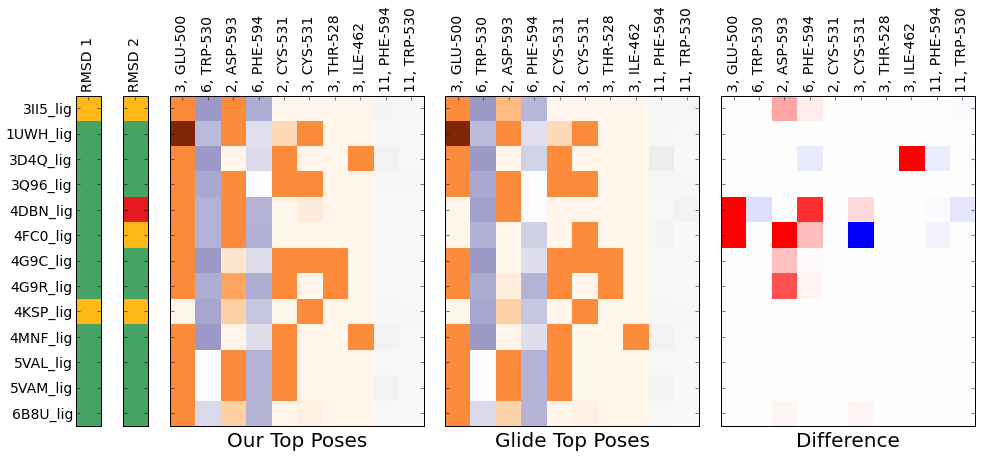

query: 3SKC_lig
us: 9.78754567934 2.29019996599
glide: 9.78754567934 2.25037247521 



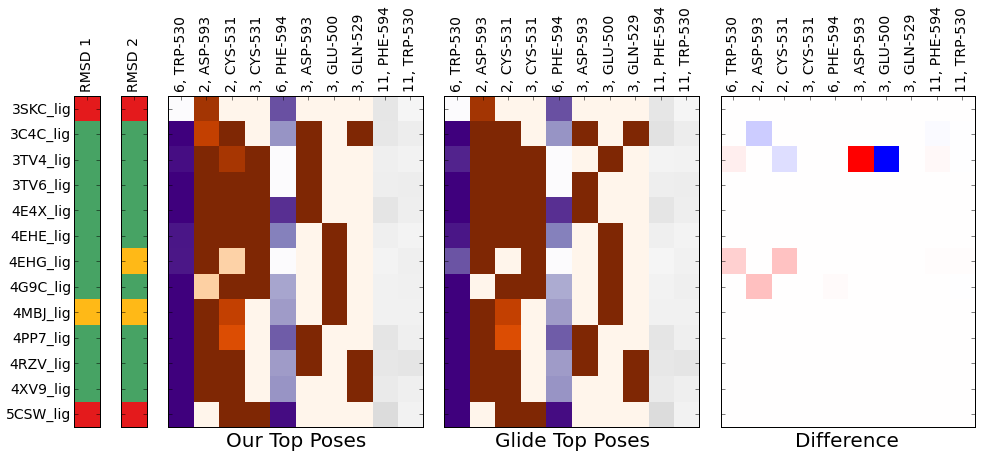

query: 4E26_lig
us: 8.01483727844 3.66488675152
glide: 8.0740765985 4.07040461126 



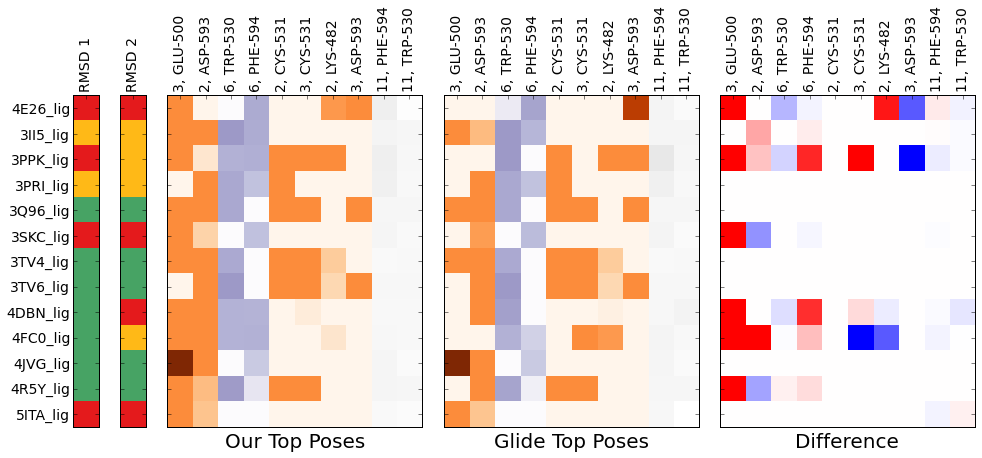

query: 4H58_lig
us: 14.7202494629 2.33367618558
glide: 3.04320522633 3.22557903568 



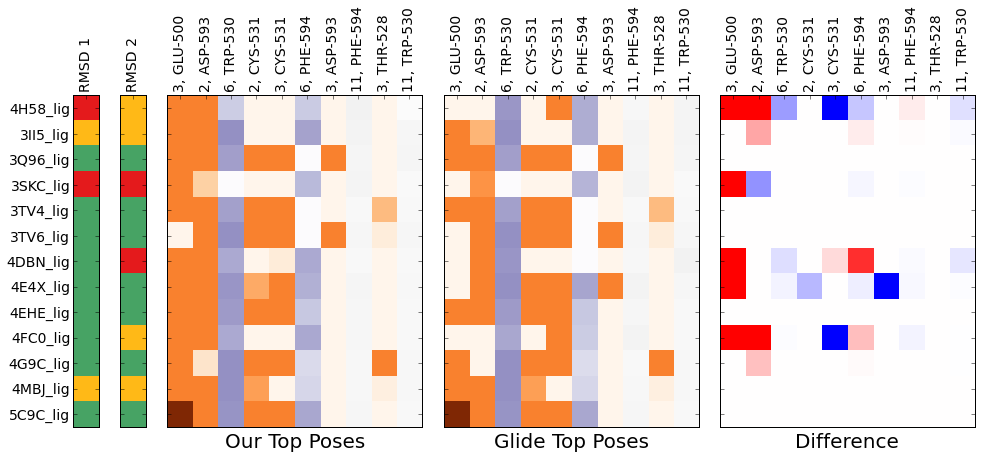

query: 5CSW_lig
us: 4.52632228286 2.39622208334
glide: 9.46280829323 2.38860746594 



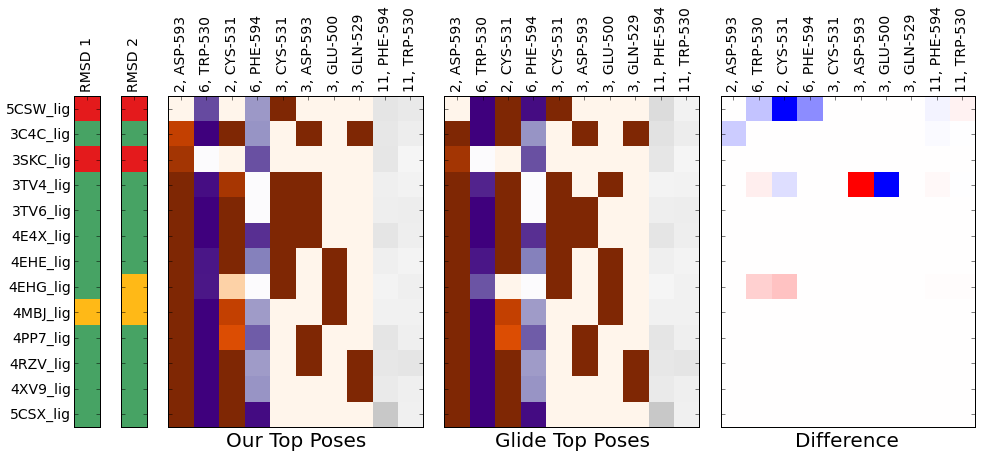

query: 5ITA_lig
us: 3.03155520573 1.69855932795
glide: 9.39772893758 1.70850978161 



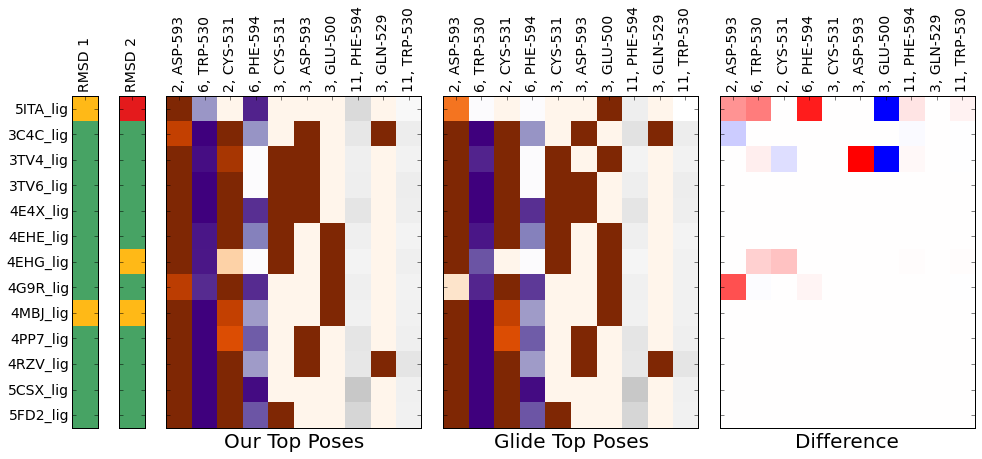

In [69]:
for q in sorted(sc.results[p].keys()):
    query_rmsd = sc.get_rmsd(p,q,q)
    helper_rmsds = [sc.get_rmsd(p,q,i) for i in sc.results[p][q] if i != q]
    
    glide_query_rmsd = sc.get_rmsd(p,q,q,glide=True)
    glide_helper_rmsds = [sc.get_rmsd(p,q,i,glide=True) for i in sc.results[p][q] if i != q]
    
    if query_rmsd > 3:
        print 'query:', q
        print 'us:', query_rmsd, np.mean(helper_rmsds)
        print 'glide:', glide_query_rmsd, np.mean(glide_helper_rmsds),'\n'
        sc.show_fps(p,q,size=1.2)
        #for f in sc.stats.features:
        #    sc.show_feature(p,q,f,size=1.5)


mcss


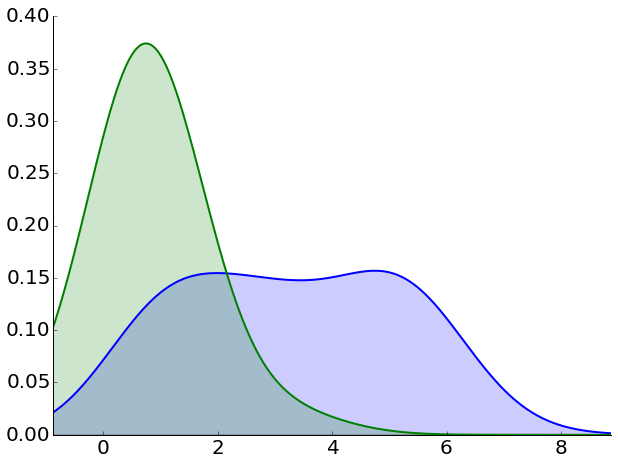

hbond


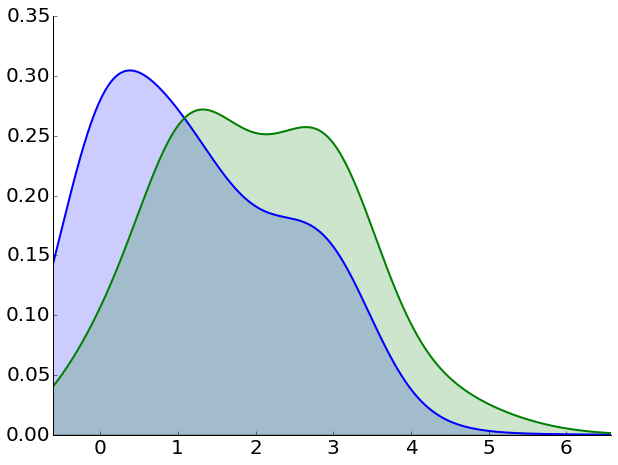

In [38]:
for f_name in sc.stats.features.keys():
    print f_name#, stats.evidence.std[f_name]
    sc.stats.show_stats(f_name, raw=False, smoothed=True)
    #stats.show_stats_by_pair(f_name, raw=False, smoothed=True)